In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 5  # Bigger images
subject_details_path = '../files/SubjectDetails.xls'

subject_details_df = pd.read_excel(subject_details_path)
subject_details_df.head()

,S/No,Study Number,Height (cm),Weight (kg),Gender,PSG Start Time,PSG AHI,BMI,Age,Epworth Sleepiness Score,Study Duration (hr),Sleep Efficiency (%),Unnamed: 12,No of data blocks in EDF
0,1,UCDDB002,172,100.3,M,0:11:04,23,33.9,54,16,6.2,84,NaN,22470
1,2,UCDDB003,179,102.0,M,23:07:50,51,31.8,48,13,7.3,81,NaN,26478
2,3,UCDDB005,176,100.4,M,23:28:42,13,32.4,65,19,6.9,63,NaN,24798
3,4,UCDDB006,185,103.5,M,23:57:14,31,30.2,52,3,6.7,89,NaN,24267
4,5,UCDDB007,183,84.0,M,23:30:22,12,25.1,47,15,6.8,90,NaN,24405


I created a function that returns the signal by searching for its corresponding header.

In [3]:
from functools import reduce

def signal_for_header(signals, signal_headers, header):
    float_index = reduce(lambda prev,curr: curr[0] if curr[1] == header else prev, map(lambda elm: (elm[0],elm[1]['label']), enumerate(signal_headers)), 0)
    print(float_index)
    assert signal_headers[float_index]['label'] == header

    return np.array(signals[float_index])

This function is then used to get the nasal airflow signal from the first participant (`S/No 1`) 

In [4]:
subject_details_df[subject_details_df['S/No'] == 1]

,S/No,Study Number,Height (cm),Weight (kg),Gender,PSG Start Time,PSG AHI,BMI,Age,Epworth Sleepiness Score,Study Duration (hr),Sleep Efficiency (%),Unnamed: 12,No of data blocks in EDF
0,1,UCDDB002,172,100.3,M,0:11:04,23,33.9,54,16,6.2,84,NaN,22470


In [5]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('../files/ucddb002.rec')
len(signals) == len(signal_headers) 
flow_signal_002 = signal_for_header(signals, signal_headers, 'Flow')

8


Find out the sample rate of our flow signal.

In [6]:
signal_headers[8]

{'label': 'Flow',
 'dimension': 'L/min',
 'sample_rate': 8.0,
 'sample_frequency': 8.0,
 'physical_max': 5.0,
 'physical_min': -5.0,
 'digital_max': 2047,
 'digital_min': -2048,
 'prefilter': 'HP:0.00 Hz      LP: 0.00 Hz',
 'transducer': 'FLOW'}

In [7]:
sample_rate = signal_headers[8]['sample_rate']

`ThinkDSP/code` is added to the list of importable modules.

In [23]:
import os
import sys
THINKDSP_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'ThinkDSP/code'))
sys.path.append(THINKDSP_DIR)

This is the raw data from the first participant's nasal airflow channel.

<AxesSubplot:>

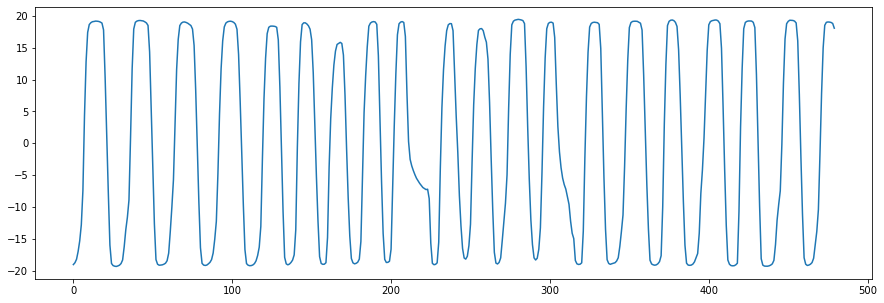

In [51]:
import thinkdsp
import seaborn as sns
seconds_window = 60 * sample_rate
mini_flow = flow_signal_002[:int(seconds_window)]
sns.lineplot(data=mini_flow)

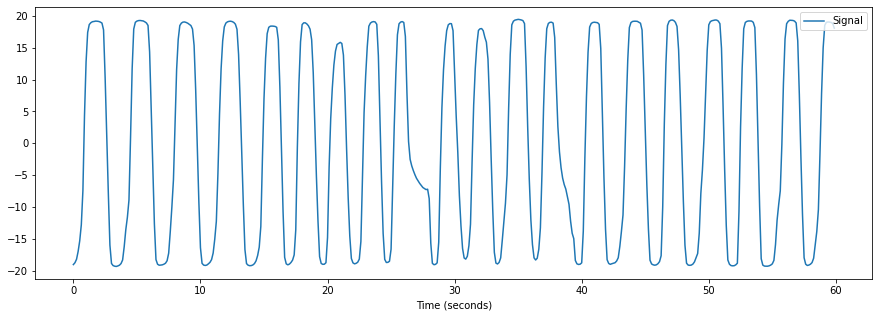

In [52]:
nk.signal_plot(mini_flow, sampling_rate=sample_rate)

In [53]:
cleaned = nk.rsp_clean(mini_flow, sampling_rate=sample_rate)
# Extract peaks
df, peaks_dict = nk.rsp_peaks(cleaned)
info = nk.rsp_fixpeaks(peaks_dict)
formatted = nk.signal_formatpeaks(info, desired_length=len(cleaned),peak_indices=info["RSP_Peaks"])

In [66]:
df.head()

,RSP_Peaks,RSP_Troughs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


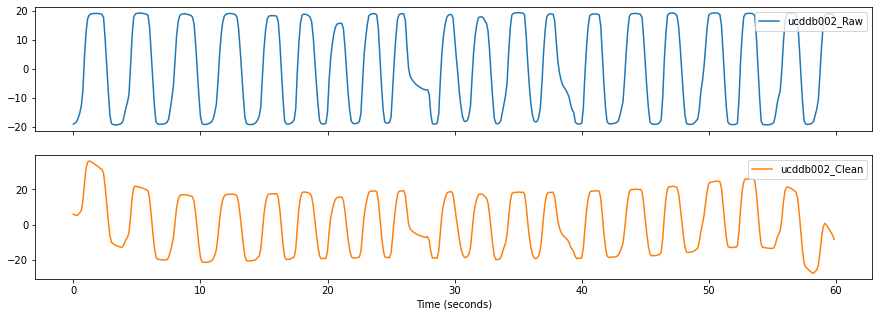

In [54]:
nk.signal_plot(pd.DataFrame({"ucddb002_Raw": mini_flow, "ucddb002_Clean": cleaned}), sampling_rate=sample_rate, subplots=True)

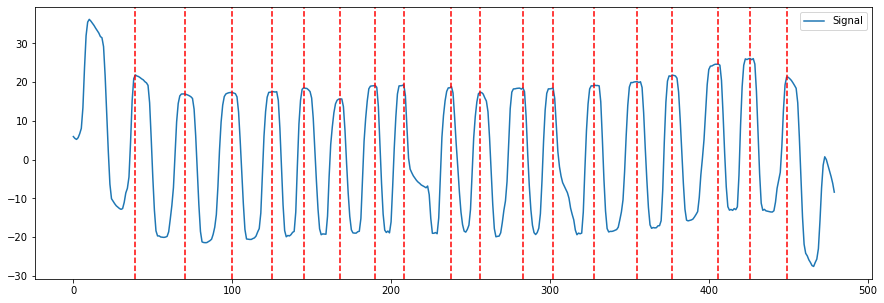

In [55]:
candidate_peaks = nk.events_plot(peaks_dict['RSP_Peaks'], cleaned)

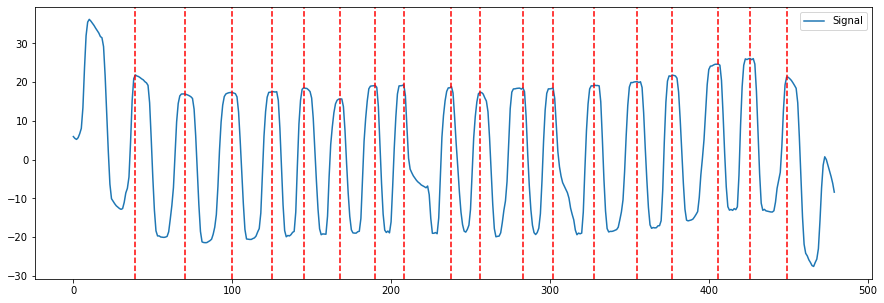

In [56]:
fixed_peaks = nk.events_plot(info['RSP_Peaks'], cleaned)

Text(0, 0.5, 'BPM')

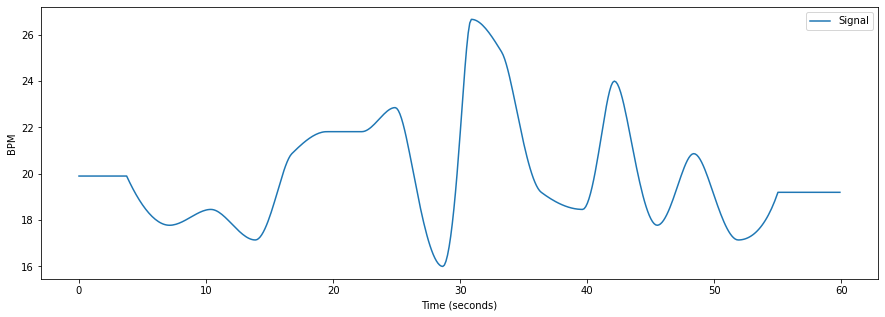

In [57]:
# Extract rate
rsp_rate = nk.rsp_rate(cleaned, peaks_dict, sampling_rate=sample_rate)

# Visualize
nk.signal_plot(rsp_rate, sampling_rate=sample_rate)
plt.ylabel('BPM')

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,648.013792,3014.705882,432.747294,669.071185,0.143545,0.214951,3125.0,555.975,0.177912,NaN,0.061955,0.026303,2.355421,NaN,NaN,473.104772,388.216842,0.820573,0.064539,-inf


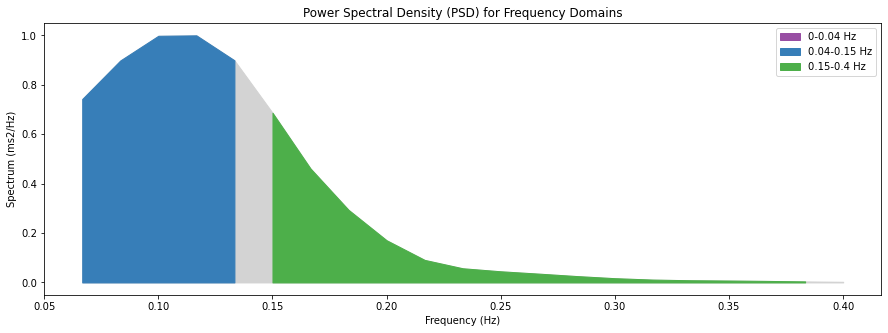

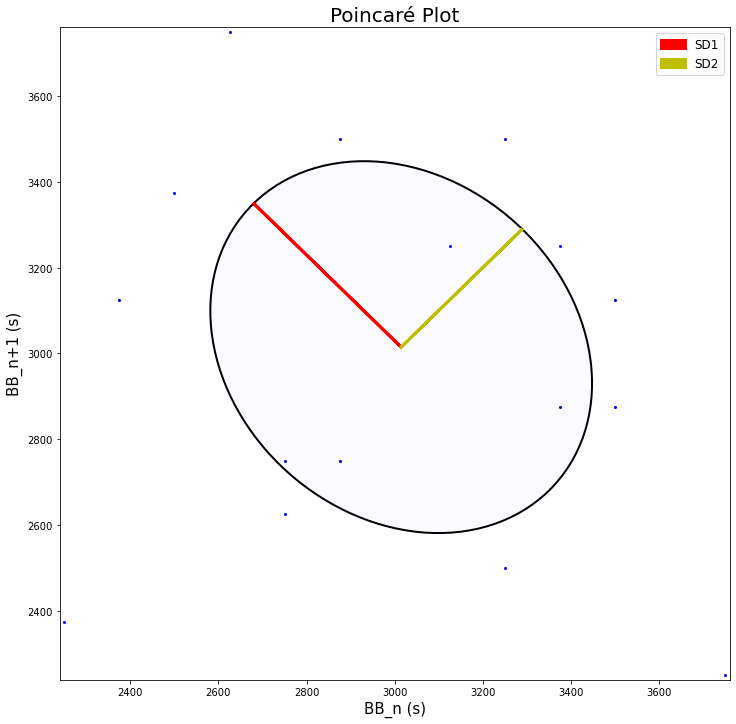

In [58]:
rrv = nk.rsp_rrv(rsp_rate, info, sampling_rate=sample_rate, show=True)
rrv

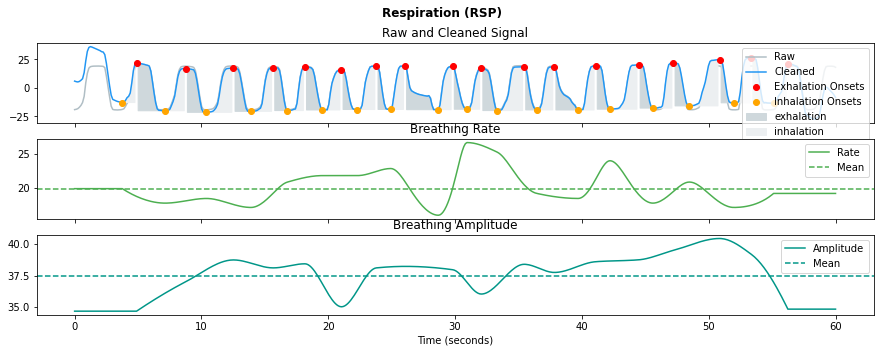

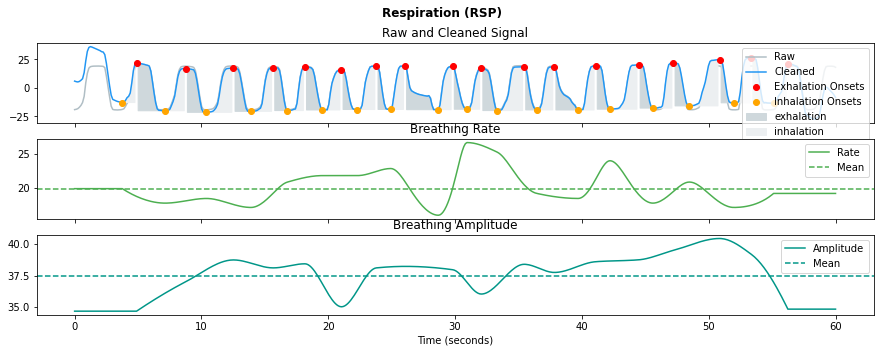

In [59]:
# Process it
signals, info = nk.rsp_process(mini_flow, sampling_rate=sample_rate)

# Visualise the processing
nk.rsp_plot(signals, sampling_rate=sample_rate)

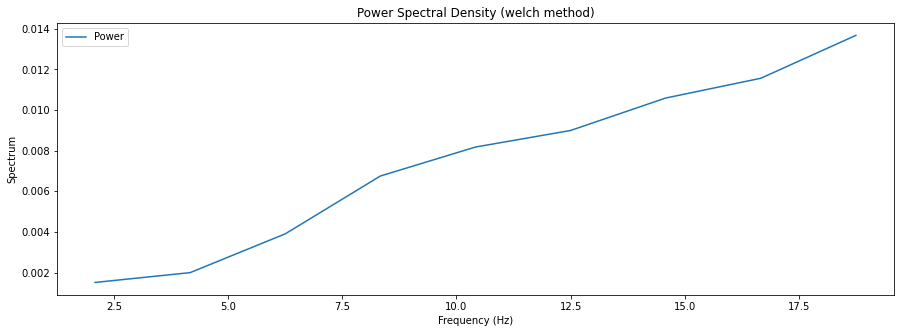

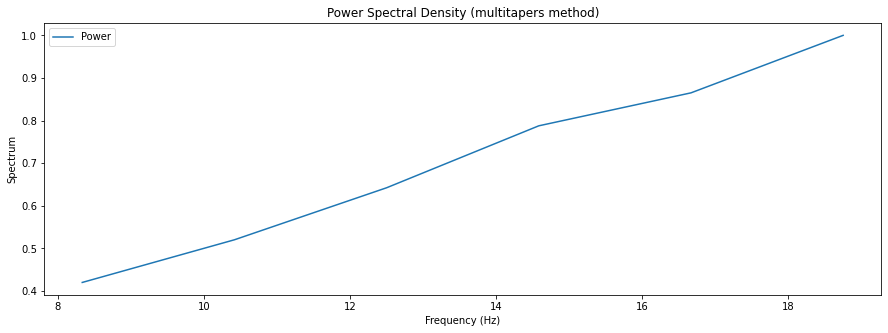

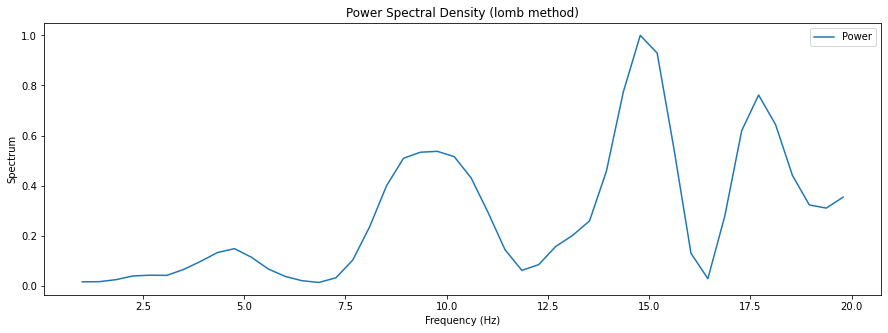

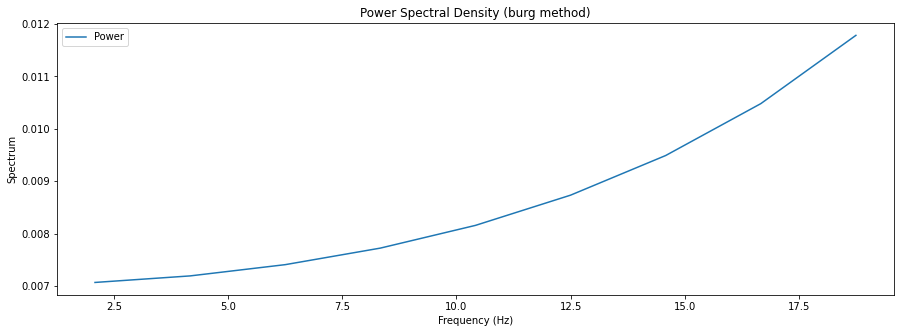

In [60]:
# Get the PSD using different methods
welch = nk.signal_psd(mini_flow, method="welch", min_frequency=1, max_frequency=20, show=True)
multitaper = nk.signal_psd(mini_flow, method="multitapers", max_frequency=20, show=True)
lomb = nk.signal_psd(mini_flow, method="lomb", min_frequency=1, max_frequency=20, show=True)
burg = nk.signal_psd(mini_flow, method="burg", min_frequency=1, max_frequency=20, order=10, show=True)

In [61]:
flow_df, info = nk.bio_process(rsp=mini_flow, sampling_rate=sample_rate)
results = nk.bio_analyze(flow_df, sampling_rate=sample_rate)

In [67]:
info

{'RSP_Peaks': array([ 39,  70, 100, 125, 145, 168, 190, 208, 238, 256, 283, 302, 328,
        355, 377, 406, 426, 449]),
 'RSP_Troughs': array([ 30,  57,  83, 111, 134, 156, 178, 199, 229, 247, 266, 291, 317,
        337, 364, 387, 415, 440]),
 'sampling_rate': 8.0}

<AxesSubplot:>

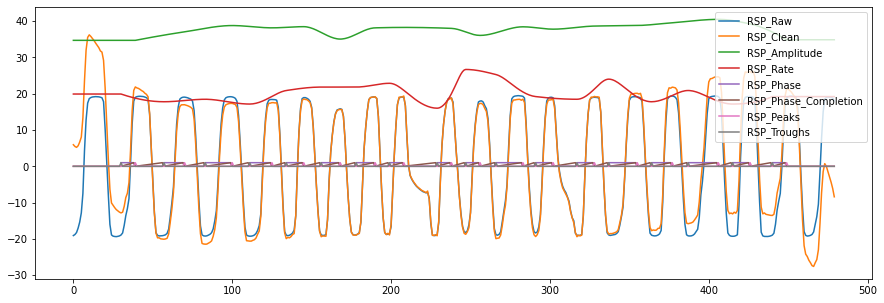

In [62]:
flow_df.plot()

In [63]:
# Half the data
results

,RSP_Rate_Mean,RSP_Amplitude_Mean,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,...,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,19.91758,37.515,1.430556,1.308824,1.093009,648.013792,3014.705882,432.747294,669.071185,0.143545,...,0.061955,0.026303,2.355421,NaN,NaN,473.104772,388.216842,0.820573,0.064539,-inf


In [82]:
t, info = nk.rsp_process(cleaned, sampling_rate=sample_rate)
t

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_Phase,RSP_Phase_Completion,RSP_Peaks,RSP_Troughs
0,5.943732,8.308762,34.654326,20.198020,NaN,0.0,0,0
1,5.461936,7.475883,34.654326,20.198020,NaN,0.0,0,0
2,5.221712,6.837845,34.654326,20.198020,NaN,0.0,0,0
3,5.658030,7.020452,34.654326,20.198020,NaN,0.0,0,0
4,6.696304,7.605922,34.654326,20.198020,NaN,0.0,0,0
...,...,...,...,...,...,...,...,...
475,-1.454466,-0.096114,36.485324,22.857143,NaN,0.0,0,0
476,-2.851582,-1.882617,36.485324,22.857143,NaN,0.0,0,0
477,-4.380135,-3.762651,36.485324,22.857143,NaN,0.0,0,0
478,-6.100063,-5.957057,36.485324,22.857143,NaN,0.0,0,0


In [102]:
def ir_sampler(signal, sampling_freq=8):
    cleaned_signal = nk.rsp_clean(signal, sampling_rate=sampling_freq)
    rsp_df, rsp_info = nk.rsp_process(cleaned_signal, sampling_rate=sampling_freq)
    n = len(rsp_df)
    apnea_interval = 8 
    baseline_interval = 4
    min_amplitude = 0.1 # protect against noise
    iri = [0] * n
    ira = [0] * n
    p_curr = 0
    assert len(rsp_info['RSP_Peaks']) == len(rsp_info['RSP_Troughs'])
    for p_min, p_max in zip(rsp_info['RSP_Troughs'], rsp_info['RSP_Peaks']):
        trough, peak = cleaned_signal[p_min], cleaned_signal[p_max]
        amplitude = peak - trough
        interval = (p_max - p_min) / 60 # respiration interval times lie in the range [0s, 60s]

        if amplitude > min_amplitude and (p_max - p_min) / sampling_freq > baseline_interval:

            if (p_min - p_curr) / sampling_freq > apnea_interval:
                # No breathing is occurrring
                print("APNEA")
                iri[p_curr:p_min] = [interval] * (p_min - p_curr)
                ira[p_curr:p_min] = [0] * (p_min - p_curr)

        iri[p_min:p_max] = [interval] * (p_max - p_min)
        ira[p_min:p_max] = [amplitude] * (p_max - p_min)
        p_curr = p_max
    return {'IRI': iri, 'IRA': ira}


In [103]:
cleaned_breaths = ir_sampler(mini_flow)

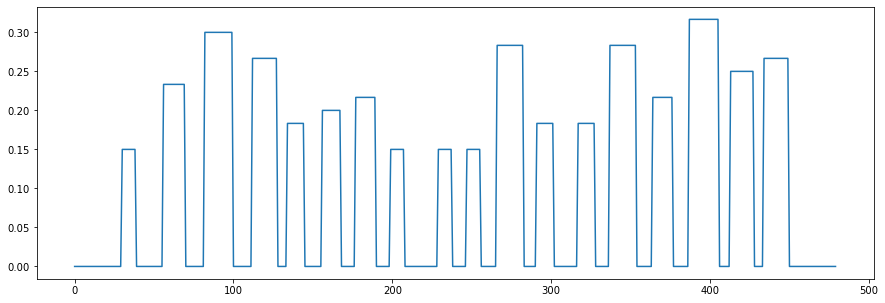

In [104]:
plt.plot(cleaned_breaths['IRI'])

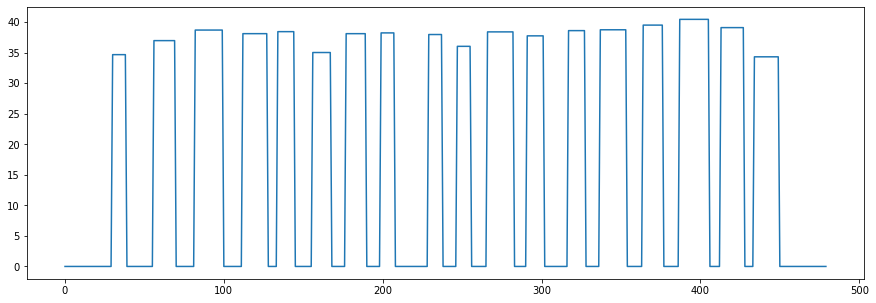

In [105]:
plt.plot(cleaned_breaths['IRA'])